# Sales and Reviews Analysis

This notebook contains Exploratory Data Analysis for Sales and Reviews.  
The objectives include:
- Top Product Categories by Total Sales.
- Average Review Score by Product Category.
- Top Product Categories by Sales.
- Total Sales by Customer Region.
- Distribution of Review Scores.

In [1]:
import psycopg2
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", message=".*pandas only supports SQLAlchemy connectable.*")
warnings.filterwarnings("ignore", category=UserWarning, module='pandas')

In [2]:
# Connecting to database
conn = psycopg2.connect(
    dbname="olist",
    user="postgres",
    password="1234",
    host="localhost",
    port="5432"
)

# Reading tables from dwh schema
fact = pd.read_sql("SELECT * FROM dwh.fact;", conn)
customers = pd.read_sql("SELECT * FROM dwh.dim_customers;", conn)
sellers = pd.read_sql("SELECT * FROM dwh.dim_sellers;", conn)

In [3]:
fact.head()

,order_id,order_item_id,product_id,seller_id,price,freight_value,total_value,product_category,customer_id,order_status,review_id,review_score,payments,installments,total_payment_value
0,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.90,19.93,259.83,pet_shop,f6dd3ec061db4e3987629fe6b26e5cce,delivered,7b07bacd811c4117b742569b04ce3580,4.0,credit_card,3,259.83
1,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.00,17.87,216.87,furniture_decor,6489ae5e4333f3693df5ad4372dab6d3,delivered,0c5b33dea94867d1ac402749e5438e8b,5.0,credit_card,5,216.87
2,00048cc3ae777c65dbb7d2a0634bc1ea,1,ef92defde845ab8450f9d70c526ef70f,6426d21aca402a131fc0a5d0960a3c90,21.90,12.69,34.59,housewares,816cbea969fe5b689b39cfc97a506742,delivered,5e4e50af3b7960b7a10d86ec869509e8,4.0,boleto,1,34.59
3,0005a1a1728c9d785b8e2b08b904576c,1,310ae3c140ff94b03219ad0adc3c778f,a416b6a846a11724393025641d4edd5e,145.95,11.65,157.60,health_beauty,16150771dfd4776261284213b89c304e,delivered,67b1ab8f3ec19d5a90f153f21757d3a1,1.0,credit_card,3,157.60
4,00061f2a7bc09da83e415a52dc8a4af1,1,d63c1011f49d98b976c352955b1c4bea,cc419e0650a3c5ba77189a1882b7556a,59.99,8.88,68.87,health_beauty,c6fc061d86fab1e2b2eac259bac71a49,delivered,7e92c32ae297ef950ee69781d9f1760c,5.0,credit_card,3,68.87


In [4]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,0ba0a7a7ab459af5b3860fa8b784ddd7,4f922e1a973e7a72b422022f4aabfd47,29102,vila velha,ES
1,72785ad5f42dc6ce2500bb83f98a0c40,7e84cccad8b5b4c96e0c07d28a039abd,84200,jaguariaiva,PR
2,ba4eec713eeb24b401bd89b380363910,aa9ca97f1eada76cd97fde1b8a4db3b6,4854,sao paulo,SP
3,643bf09ef6456d014d184adcef520b40,8f8ca19d3132dd627c49b5d065d6297b,14171,sertaozinho,SP
4,1bc53b9a233400e4060e63417a8b9cc6,eaf44ee5ceb454b1383c1e2d26b9beaf,1048,sao paulo,SP


In [5]:
sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,117cfc326c6d50da67ca858ff5c0c852,25530,sao joao de meriti,RJ
1,3a734b715d333a2588a3d54a0c9b8746,6132,osasco,SP
2,5a425cc503b39b262a847fd6212bf53b,86010,londrina,PR
3,ac137bac82ffa8548e62bd9d01d2a14f,3631,sao paulo,SP
4,717b78b0950b51ed00b1471d858b0edc,18220,alambari,SP


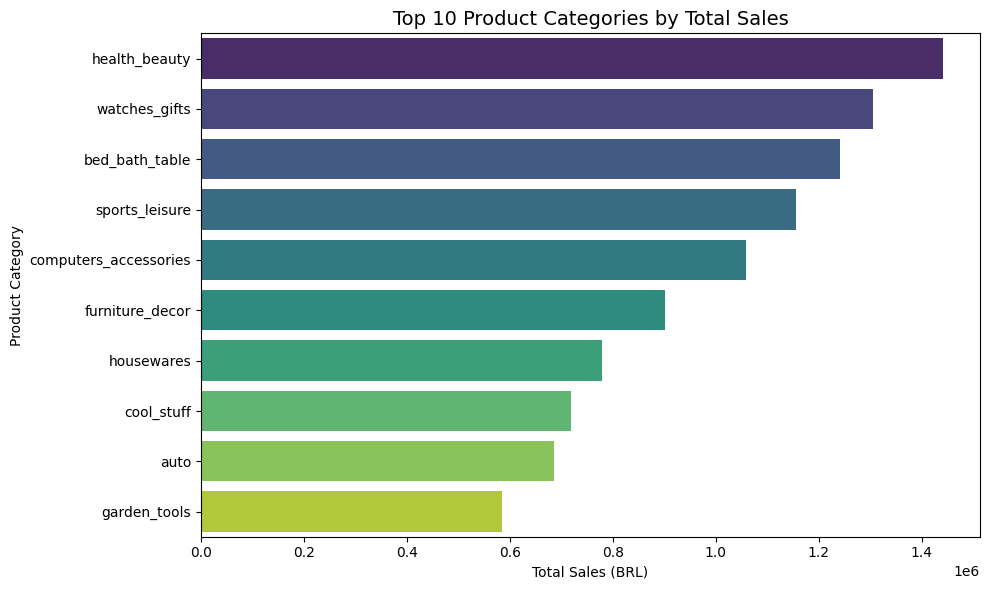

In [6]:
# 1. Merge the fact data with customers and sellers to get location info 
# Merge fact + customers to attach customer city and state
fact_customers = pd.merge(fact, customers, on='customer_id', how='left')

# Merge the result with sellers to include seller city and state
full_data = pd.merge(fact_customers, sellers, on='seller_id', how='left')

# 2. Compute total sales by category and region (customer_state) 
sales_by_cat_region = (
    full_data.groupby(['product_category', 'customer_state'], as_index=False)
    .agg(total_sales=('total_value', 'sum'),
         avg_price=('price', 'mean'),
         num_orders=('order_id', 'nunique'))
    .sort_values(by='total_sales', ascending=False)
)

# 3. Top product categories by total sales (nationwide) 
top_categories = (
    full_data.groupby('product_category', as_index=False)
    .agg(total_sales=('total_value', 'sum'))
    .sort_values(by='total_sales', ascending=False)
    .head(10)
)

# 4. Visualization: Top 10 categories by sales using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_categories,
    x='total_sales',
    y='product_category',
    hue='product_category',     # Add hue to match palette use
    palette='viridis',
    legend=False                # Hide unnecessary legend
)
plt.title('Top 10 Product Categories by Total Sales', fontsize=14)
plt.xlabel('Total Sales (BRL)')
plt.ylabel('Product Category')
plt.tight_layout()
plt.show()

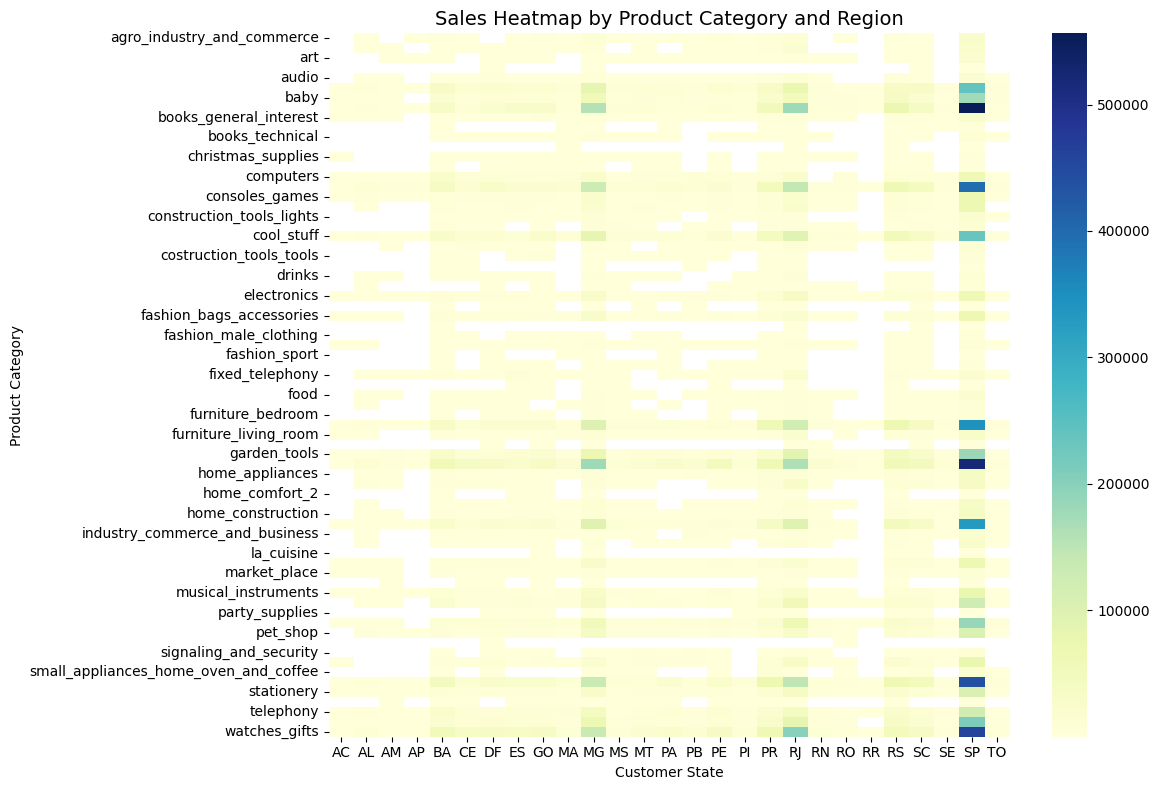

In [7]:
# 5. Visualization: Interactive heatmap of sales by category and region 
fig = px.treemap(
    sales_by_cat_region,
    path=['customer_state', 'product_category'],
    values='total_sales',
    color='total_sales',
    color_continuous_scale='Viridis',
    title='Sales Distribution by Category and Region'
)
fig.show()

# 6. Visualization: Category sales by region (static heatmap using Seaborn) 
pivot_sales = sales_by_cat_region.pivot(
    index='product_category',
    columns='customer_state',
    values='total_sales'
)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_sales, cmap='YlGnBu')
plt.title('Sales Heatmap by Product Category and Region', fontsize=14)
plt.xlabel('Customer State')
plt.ylabel('Product Category')
plt.tight_layout()
plt.show()

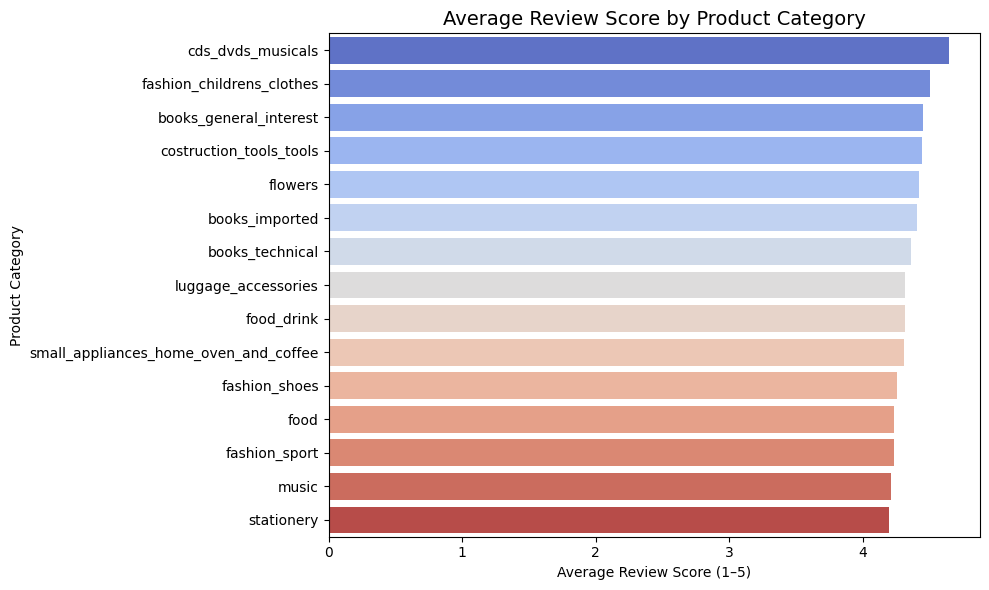

In [8]:
# 6. Merge the datasets again to bring customer and region info ---
fact_customers = pd.merge(fact, customers, on='customer_id', how='left')
full_data = pd.merge(fact_customers, sellers, on='seller_id', how='left')

# 7. Average review score by product category ---
review_by_category = (
    full_data.groupby('product_category', as_index=False)
    .agg(avg_review=('review_score', 'mean'),
         review_count=('review_score', 'count'))
    .sort_values(by='avg_review', ascending=False)
)

# 8. Average review score by customer region/state ---
review_by_region = (
    full_data.groupby('customer_state', as_index=False)
    .agg(avg_review=('review_score', 'mean'),
         review_count=('review_score', 'count'))
    .sort_values(by='avg_review', ascending=False)
)

# 9. Visualization: Average review score by category (Seaborn) ---
plt.figure(figsize=(10, 6))
sns.barplot(
    data=review_by_category.head(15),
    x='avg_review',
    y='product_category',
    hue='product_category',
    palette='coolwarm',
    legend=False
)
plt.title('Average Review Score by Product Category', fontsize=14)
plt.xlabel('Average Review Score (1–5)')
plt.ylabel('Product Category')
plt.tight_layout()
plt.show()

In [9]:
# 10 Basic KPIs 
total_sales = fact['total_value'].sum()
total_orders = fact['order_id'].nunique()
total_customers = fact['customer_id'].nunique()
avg_order_value = total_sales / total_orders
avg_review_score = fact['review_score'].mean()

print("E-Commerce KPIs Summary")
print(f"Total Sales: {total_sales:,.2f} BRL")
print(f"Total Orders: {total_orders:,}")
print(f"Unique Customers: {total_customers:,}")
print(f"Average Order Value (AOV): {avg_order_value:,.2f} BRL")
print(f"Average Review Score: {avg_review_score:.2f}/5.0")

E-Commerce KPIs Summary
Total Sales: 15,843,553.24 BRL
Total Orders: 98,666
Unique Customers: 98,666
Average Order Value (AOV): 160.58 BRL
Average Review Score: 4.03/5.0


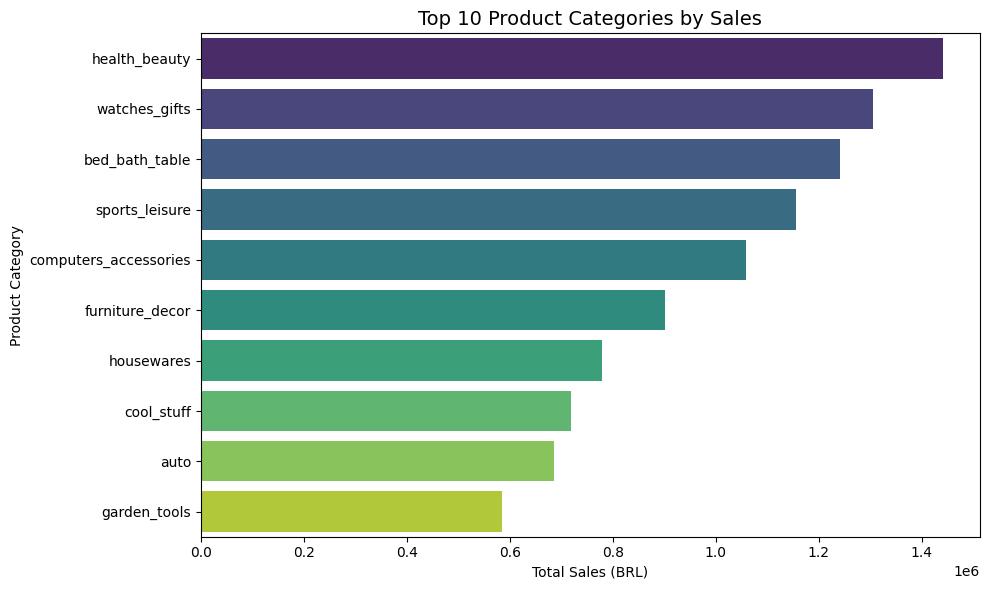

In [10]:
# 11. Top 10 Product Categories by Total Sales ---
top_categories = (
    fact.groupby('product_category', as_index=False)
    .agg(total_sales=('total_value', 'sum'))
    .sort_values(by='total_sales', ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_categories,
    x='total_sales',
    y='product_category',
    hue='product_category',
    palette='viridis',
    legend=False
)
plt.title('Top 10 Product Categories by Sales', fontsize=14)
plt.xlabel('Total Sales (BRL)')
plt.ylabel('Product Category')
plt.tight_layout()
plt.show()

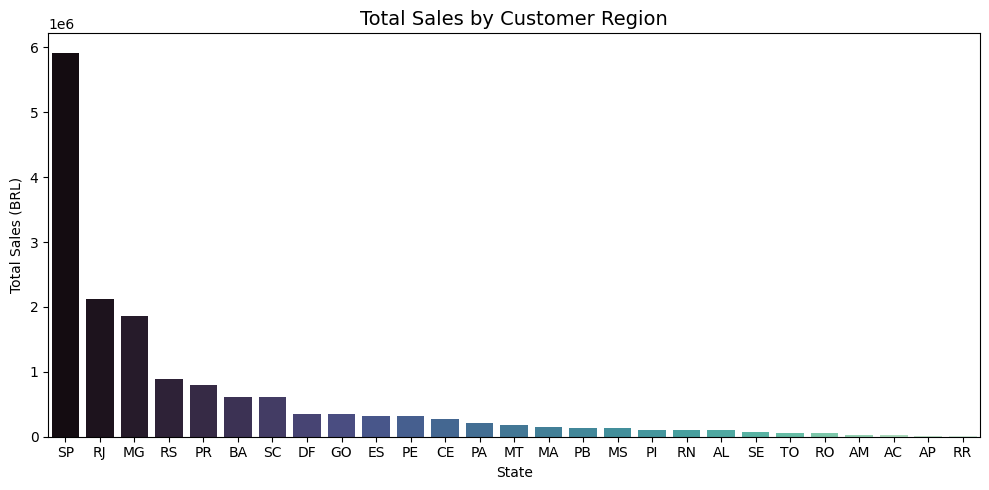

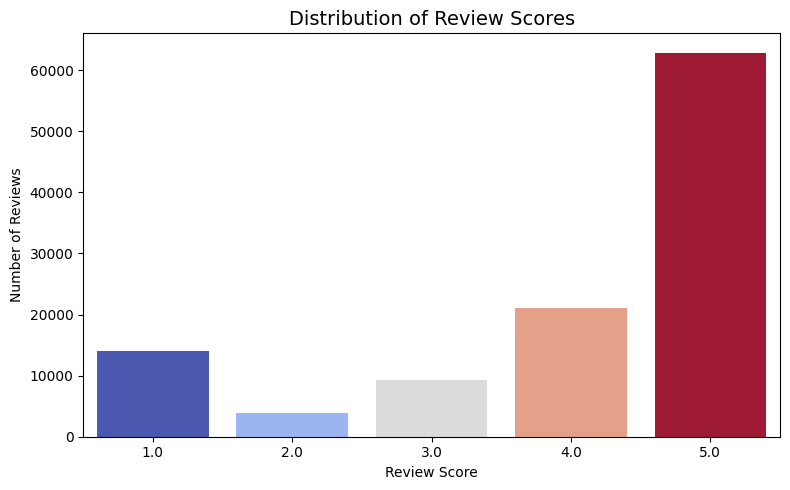

In [11]:
# 12. Sales by Region (customer_state) 
fact_customers = pd.merge(fact, customers, on='customer_id', how='left')

sales_by_region = (
    fact_customers.groupby('customer_state', as_index=False)
    .agg(total_sales=('total_value', 'sum'))
    .sort_values(by='total_sales', ascending=False)
)

plt.figure(figsize=(10, 5))
sns.barplot(
    data=sales_by_region,
    x='customer_state',
    y='total_sales',
    hue='customer_state', 
    palette='mako',
    legend=False           
)
plt.title('Total Sales by Customer Region', fontsize=14)
plt.xlabel('State')
plt.ylabel('Total Sales (BRL)')
plt.tight_layout()
plt.show()


# 13. Review Score Distribution 
plt.figure(figsize=(8, 5))
sns.countplot(
    data=fact,
    x='review_score',
    hue='review_score',        
    palette='coolwarm',
    legend=False
)
plt.title('Distribution of Review Scores', fontsize=14)
plt.xlabel('Review Score')
plt.ylabel('Number of Reviews')
plt.tight_layout()
plt.show()
